In [27]:
import ee
from random import randint
from ee import batch
from IPython.display import Image
import pandas as pd
import numpy as np

In [2]:
ee.Initialize()

In [5]:
roi_app1 = ee.FeatureCollection('ft:1d80zsjZAW6wudXeTBOxg-akjEauImi3nzO504Kty')
VB = ee.Image('users/gcarrasco/VB')
ML_1 = ee.Image('users/gcarrasco/ML_1')
ML_2 = ee.Image('users/gcarrasco/ML_2')
ML_3 = ee.Image('users/gcarrasco/ML_3')
SL = ee.Image('users/gcarrasco/SL')
UM = ee.Image('users/gcarrasco/UM')
LI = ee.Image('users/gcarrasco/LI')
collection_rgb = ee.ImageCollection([VB,ML_1,ML_2,ML_3,SL,UM,LI])
collection_m = ee.ImageCollection('users/edgarmanrique30/comunities')
geometry = ee.FeatureCollection('ft:1O-lP3K4Po6HV2MNvLwPheszU_lnGihdKCxaBbuuT')
geometry = geometry.geometry()

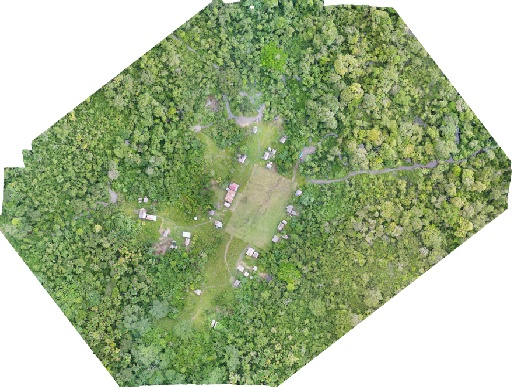

In [6]:
url = VB.getThumbUrl({'min':0, 'max':255})
Image(url=url, embed=True, format='png')

In [7]:
def __maskvaluesmulti__(img):
	mask = img.neq(0)
	return img.mask(mask)
def __maskvaluesrgb__(img):
	mask = img.neq(255)
	return img.mask(mask)
def addndvi(img):
	ndvi = img.expression('(NIR-RED)/(NIR+RED)', {
		'NIR': img.select('NIR'),
		'RED': img.select('red_m')
		}).rename('NDVI')
	return img.addBands(ndvi)
def __clip_col__(img): return img.clip(geometry)
def __renameBandsRGB__ (img):return img.rename(['red','green','blue','mask'])
def __renameBandsMulti__(img):return img.rename(['red_m','green_m','Edge Red','NIR'])

In [8]:
#masking values
collection_rgb = collection_rgb.map(__maskvaluesrgb__)
collection_m = collection_m.map(__maskvaluesmulti__)
#clipping extent
collection_rgb = collection_rgb.map(__clip_col__)
collection_m = collection_m.map(__clip_col__)
#renaming bands
collection_rgb = collection_rgb.map(__renameBandsRGB__)
collection_m = collection_m.map(__renameBandsMulti__)
#converting collection to single images
collection_rgb = collection_rgb.median()
collection_m = collection_m.median()
#getting a new image with all the bands
image = collection_rgb.select(['red', 'green', 'blue']).addBands(collection_m, ['red_m','green_m','Edge Red','NIR'])
image = addndvi(image)
#training samples for sequoia images
polygons= ee.FeatureCollection(roi_app1,"geometry");
classifier = ee.Classifier.randomForest(20)
#specifying bands to use 
bands = ['red', 'green', 'blue', 'red_m','green_m','Edge Red','NIR']

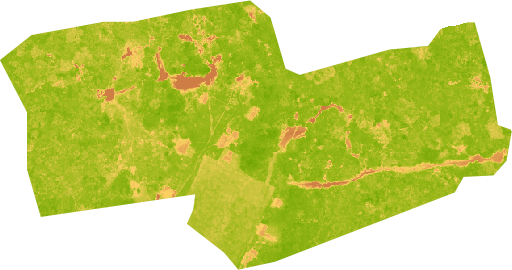

In [25]:
image_ndvi = image.visualize(**{'bands':'NDVI','min':-0.4, 'max':0.7, 'palette':'ce7e45,fcd163,99b718,66a000,023b01'}) 
url = image_ndvi.getThumbUrl({'region':geometry.geometries().get(1).getInfo()})
Image(url=url, embed=True, format='png')

In [57]:
def kfold_randomforest (polygons, seed):
	polygon_rancol = polygons.randomColumn('random',seed)

	regionsOfInterest = image.select(bands).sampleRegions(polygon_rancol,['class', 'random'],2)

	training1 = regionsOfInterest.filterMetadata('random', 'less_than', 0.8).filterMetadata('random', 'not_less_than', 0)
	testing1 = regionsOfInterest.filterMetadata('random', 'less_than', 1).filterMetadata('random', 'not_less_than', 0.8)

	trainingClassifier1 = classifier.train(training1, 'class',bands)
	validation1 = testing1.classify(trainingClassifier1)
	errorMatrix1 = validation1.errorMatrix('class', 'classification')

	training2 = regionsOfInterest.filterMetadata('random', 'less_than', 1).filterMetadata('random', 'not_less_than', 0.8)
	training22 = regionsOfInterest.filterMetadata('random', 'less_than', 0.6).filterMetadata('random', 'not_less_than', 0)
	training2 = training2.merge(training22)
	testing2 = regionsOfInterest.filterMetadata('random', 'less_than', 0.8).filterMetadata('random', 'not_less_than', 0.6)

	trainingClassifier2 = classifier.train(training2, 'class',bands)
	validation2 = testing2.classify(trainingClassifier2)
	errorMatrix2 = validation2.errorMatrix('class', 'classification')

	training3 = regionsOfInterest.filterMetadata('random', 'less_than', 1).filterMetadata('random', 'not_less_than', 0.6)
	training33 = regionsOfInterest.filterMetadata('random', 'less_than', 0.4).filterMetadata('random', 'not_less_than', 0)
	training3 = training2.merge(training33)
	testing3 = regionsOfInterest.filterMetadata('random', 'less_than', 0.6).filterMetadata('random', 'not_less_than', 0.4)

	trainingClassifier3 = classifier.train(training3, 'class',bands)
	validation3 = testing3.classify(trainingClassifier3)
	errorMatrix3 = validation3.errorMatrix('class', 'classification')

	training4 = regionsOfInterest.filterMetadata('random', 'less_than', 1).filterMetadata('random', 'not_less_than', 0.4)
	training44 = regionsOfInterest.filterMetadata('random', 'less_than', 0.2).filterMetadata('random', 'not_less_than', 0)
	training4 = training4.merge(training44)
	testing4 = regionsOfInterest.filterMetadata('random', 'less_than', 0.4).filterMetadata('random', 'not_less_than', 0.2)

	trainingClassifier4 = classifier.train(training4, 'class',bands)
	validation4 = testing4.classify(trainingClassifier4)
	errorMatrix4 = validation4.errorMatrix('class', 'classification')

	training5 = regionsOfInterest.filterMetadata('random', 'less_than', 1).filterMetadata('random', 'not_less_than', 0.2)
	testing5 = regionsOfInterest.filterMetadata('random', 'less_than', 0.2).filterMetadata('random', 'not_less_than', 0)

	trainingClassifier5 = classifier.train(training5, 'class',bands)
	validation5 = testing5.classify(trainingClassifier5)
	errorMatrix5 = validation5.errorMatrix('class', 'classification')

	suma = ee.Number(errorMatrix1.accuracy()).add(ee.Number(errorMatrix2.accuracy())).add(ee.Number(errorMatrix3.accuracy())).add(ee.Number(errorMatrix4.accuracy())).add(ee.Number(errorMatrix5.accuracy()))
	mean = suma.divide(5)
	return mean.getInfo()

In [59]:
means = {}
k = 0
while k < 10:
    key = k
    value = kfold_randomforest(polygons, randint(0,999))
    means[key] = value 
    k += 1

In [65]:
df = pd.DataFrame(means.items(), columns = ['order', 'mean']) 
print df
df["mean"].mean()

   order      mean
0      0  0.894095
1      1  0.908961
2      2  0.913142
3      3  0.912526
4      4  0.918774
5      5  0.907859
6      6  0.884862
7      7  0.908590
8      8  0.888653
9      9  0.903954


0.90414160528956344